# Classifiers comparison
_María Camila Vásquez Correa_

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from bhtsne import tsne
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, auc
%matplotlib inline

## Data
The data shows 8 features of 1000 students that took a test involving math, reading and writing. 
In this excercise we aim to identify whether or not the student took a preparation course for the test, given the other 7 features in the dataset.

In [2]:
data = pd.read_csv('StudentsPerformance.csv')

In [3]:
data.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')

## Preprocessing
The steps for the preprocessing of the data include:
* Encoding the categorical variables, to map them into a discrete numeric space
* Normalization of the numeric variables
* Embbeding via BH-tsne
* Dividing the data set into training, validation and test

In [4]:
categorical_vars = list(data.columns[0:5])

In [5]:
categorical_vars

['gender',
 'race/ethnicity',
 'parental level of education',
 'lunch',
 'test preparation course']

In [6]:
df_raw = data[categorical_vars]
df_temp = df_raw.astype("category").apply(lambda x: x.cat.codes)
data[categorical_vars] = df_temp.where(~df_raw.isna(), df_raw)
continuous_vars = data.columns.difference(categorical_vars)

In [7]:
X = data.drop('test preparation course', axis = 1)
X = X.astype(np.float64)
y = data['test preparation course']

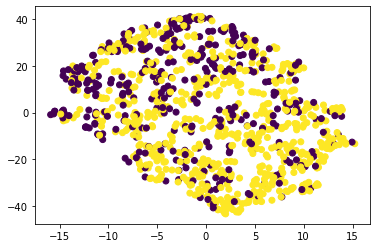

In [8]:
X_e = tsne(data.drop('test preparation course', axis = 1).astype(np.float64))
plt.scatter(X_e[:, 0], X_e[:, 1], c=y)
plt.show()

In [9]:
min_max_scaler = preprocessing.MinMaxScaler()
X_e = min_max_scaler.fit_transform(X_e)

In [10]:
min_max_scaler = preprocessing.MinMaxScaler()
data[continuous_vars]= min_max_scaler.fit_transform(data[continuous_vars])
X = data.drop('test preparation course', axis = 1)
X = X.astype(np.float64)
y = data['test preparation course']

In [11]:
cat_x = X.columns[0:4]

In [12]:
enc = OneHotEncoder(sparse = False)
a = enc.fit_transform(X[cat_x])
a = pd.DataFrame(a)
X = pd.concat([a,X], axis = 1)
X = X.drop(cat_x, axis = 1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [14]:
X_etrain, X_etest, y_etrain, y_etest = train_test_split(X_e, y, test_size=0.2, random_state=1)

X_etrain, X_eval, y_etrain, y_eval = train_test_split(X_etrain, y_etrain, test_size=0.25, random_state=1)

### PAC learning guarantee
For a fixed confidence $\delta$ and a sample size $m$ it is possible to find the minimun error $\varepsilon$ that the classifier can achieve, given its VC dimension $d$.

In [15]:
def find_error(delta, m, d):
    return (1/m)*(d + np.log(1/delta))

In [16]:
# let us fix the confidence
delta = 0.05
m = X_train.shape[0]
n = X_train.shape[1] # Number of dimensions

## Classifiers

### Logistic regression

In [17]:
from sklearn.linear_model import LogisticRegression
from numpy import interp

In [18]:
# It is only guaranteed if the real h is in the class!
d = n + 1
print('Maximum error guaranteed: ', find_error(delta, m, d))

Maximum error guaranteed:  0.03665955378925665


In [19]:
logistic = LogisticRegression(max_iter = 100000)
logistic.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
print('Training error', np.sum(logistic.predict(X_train) == y_train)/len(y_train))

Training error 0.6916666666666667


In [21]:
print('Test error: ', np.sum(logistic.predict(X_test) == y_test)/len(y_test))

Test error:  0.725


In [22]:
def plot_auc_kfold(classifier, name, n_splits = 6): 
    cv = StratifiedKFold(n_splits)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X_val, y_val)):
        classifier.fit(X_val.values[train], y_val.values[train])
        viz = plot_roc_curve(classifier, X_val.values[test], y_val.values[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic example")
    ax.legend(loc="lower right")
    plt.show()
    fig.savefig(name)

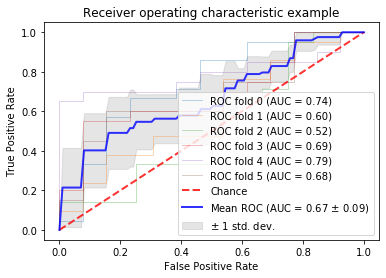

In [23]:
plot_auc_kfold(LogisticRegression(),name = 'lr-kf-c')

In [24]:
def plot_roc_test(classifier, name):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots()
    roc_auc = auc(fpr, tpr)
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    fig.savefig(name)

In [38]:
def get_auc_test(classifier):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    return roc_auc

In [59]:
def get_auc_kfold(classifier):
    cv = StratifiedKFold(n_splits = 6)
    aucs = []

    for i, (train, test) in enumerate(cv.split(X_val, y_val)):
        classifier.fit(X_val.values[train], y_val.values[train])
        y_pred = classifier.predict(X_val.values[test])
        fpr, tpr, _ = roc_curve(y_val.values[test], y_pred)
        aucs.append(auc(fpr, tpr))
        
    mean_auc = np.mean(aucs)
    return mean_auc

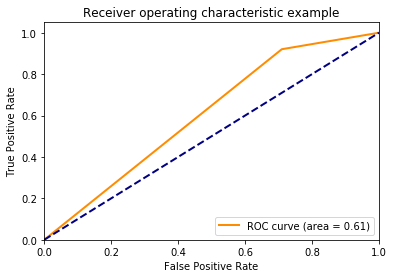

In [56]:
plot_roc_test(LogisticRegression(), name = 'lr-test-c')

### Decision tree

In [57]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
max_depth = 5

In [29]:
d = 2 ** max_depth
print('Maximum error guaranteed: ', find_error(delta, m, d))

Maximum error guaranteed:  0.05832622045592332


In [30]:
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

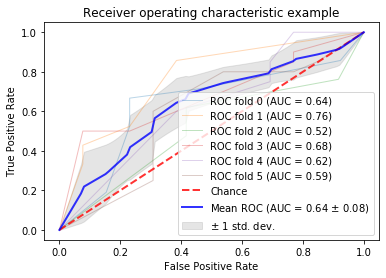

In [31]:
plot_auc_kfold(DecisionTreeClassifier(max_depth = 5), name = 'dt-kf-c')

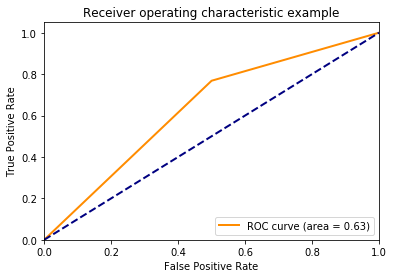

In [32]:
plot_roc_test(DecisionTreeClassifier(max_depth = 5), name = 'dt-test-c')

### Support vector machine
This classifier is going to be evaluated with 3 kernels:
* Linear (no kernel)
* Polynomial
* Radial Basis Kernel

In [33]:
from sklearn.svm import SVC
from math import factorial

In [34]:
d = n + 1 # Linear kernel
print('Maximum error guaranteed: ', find_error(delta, m, d))

Maximum error guaranteed:  0.03665955378925665


In [35]:
degree = 3 # default for polynomial kernel
d = factorial(degree + n)/(factorial(degree)*factorial(n))
print('Maximum error guaranteed: ', find_error(delta, m, d))

Maximum error guaranteed:  2.221659553789257


In [36]:
clf2 = SVC(kernel = 'rbf')
clf2.fit(X_train,y_train)
print(np.sum(clf2.predict(X_test) == y_test), len(y_test))

135 200


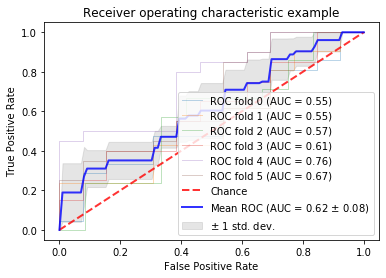

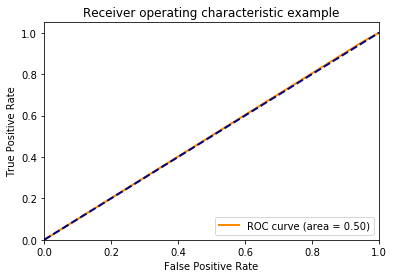

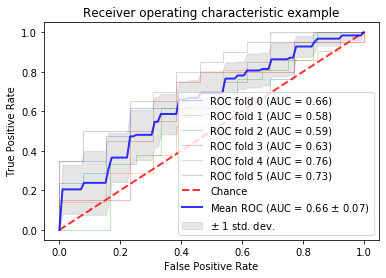

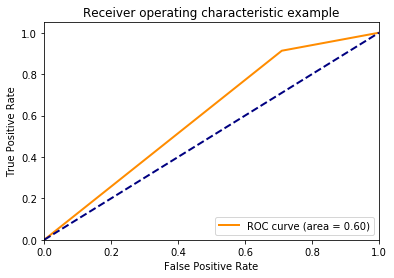

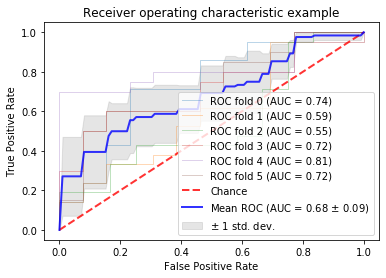

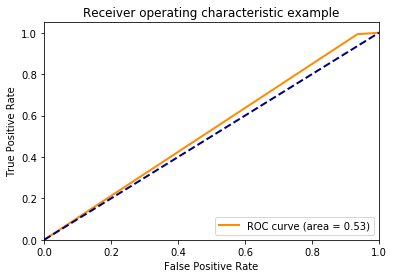

In [37]:
for i in ['rbf', 'poly', 'linear']:
    plot_auc_kfold(SVC(kernel = i), name = 'svm-'+i+'-kf-c')
    plot_roc_test(SVC(kernel = i), name = 'svm-'+i+'-test-c')

### Multi-layer perceptron
This classifier is going to be evaluated with this combination of parameters:
* Hidden layers: 1 to 3
* Number of neurons in each hidden layer: 1 to 3
* Learning rate: 0.2, 0.5, 0.9

In [41]:
from sklearn.neural_network import MLPClassifier

In [42]:
nn =  MLPClassifier(hidden_layer_sizes=tuple((np.zeros((1,2)) + 2)[0]), learning_rate_init=.9)

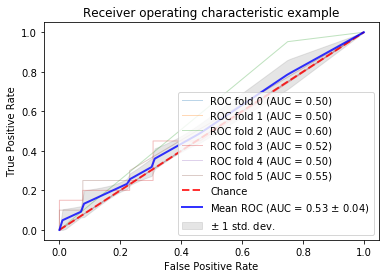

In [45]:
plot_auc_kfold(MLPClassifier(hidden_layer_sizes=(3,3,3), learning_rate_init=.2), name = '')